<a href="https://colab.research.google.com/github/ssv273/Recom_systems/blob/master/hw_webinar_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
!pip install implicit

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path_1 = '/content/drive/My Drive/Recomendation_systems/src'
module_path_2 = '/content/drive/My Drive/Recomendation_systems/'
if module_path_1 not in sys.path:
    sys.path.append(module_path_1)
if module_path_2 not in sys.path:
    sys.path.append(module_path_2)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [4]:
data = pd.read_csv('/content/drive/My Drive/Recomendation_systems/Data/retail_train.csv')
item_features = pd.read_csv('/content/drive/My Drive/Recomendation_systems/Data/product.csv')
user_features = pd.read_csv('/content/drive/My Drive/Recomendation_systems/Data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [5]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Decreased # items from 83685 to 5001


In [6]:
recommender = MainRecommender(data_train_lvl_1)

In [7]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1044078, 871756, 844179, 1046545]

In [8]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [9]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1042907, 1044078, 1062863, 934399]

In [10]:
recommender.get_similar_users_recommendation(2375, N=5)

[10457044, 921406, 1124971, 12523928, 974265]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [11]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [0]:
# your_code

In [13]:
np.setdiff1d(data_val_lvl_1['user_id'], data_train_lvl_1['user_id']).tolist()

[296, 1813, 1984]

In [0]:
users_train_lvl_1 = data_train_lvl_1['user_id'].unique()

In [0]:
result_lvl_1 = result_lvl_1[result_lvl_1['user_id'].isin(users_train_lvl_1)]

In [16]:
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


Отбор кандидатов

In [17]:
%%time
result_lvl_1['als_recommendations'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))


CPU times: user 27.7 s, sys: 19.7 s, total: 47.4 s
Wall time: 24.1 s


In [18]:
%%time
result_lvl_1['own_recommendations'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

CPU times: user 6.71 s, sys: 145 ms, total: 6.86 s
Wall time: 6.78 s


In [19]:
%%time
result_lvl_1['similar_items_recommendations'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))

CPU times: user 21.7 s, sys: 13.8 s, total: 35.5 s
Wall time: 18 s


In [0]:
# result_lvl_1['similar_users_recommendations'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))
# падает с ошибкой "userid is out of bounds of the user_items matrix"

In [0]:
rec_dict = {
            'ALS' : 0,
            'OWN' : 0,
            'SIM_ITEMS' : 0
            }

In [0]:
rec_dict['ALS'] = result_lvl_1.apply(lambda row: recall_at_k(row['als_recommendations'], row['actual']), axis=1).mean()
rec_dict['OWN'] = result_lvl_1.apply(lambda row: recall_at_k(row['own_recommendations'], row['actual']), axis=1).mean()
rec_dict['SIM_ITEMS'] = result_lvl_1.apply(lambda row: recall_at_k(row['similar_items_recommendations'], row['actual']), axis=1).mean()

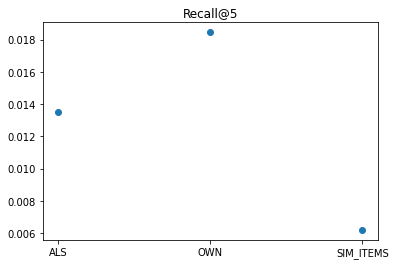

In [23]:
fig, ax = plt.subplots()
ax.scatter(rec_dict.keys(), rec_dict.values())
ax.set_title('Recall@5');

как мы видим,кандидаты отобранные с помощью own recommendtions + top-popular дают лучший recall

### B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}

In [0]:
k_numbers = [5, 20, 50, 100, 200, 500]
k_candidates = [20, 50, 100, 200, 500]

In [0]:
rec_dict_1 = {}

In [26]:
%%time
for n_candidates in k_candidates:
  res_list = []
  result_lvl_1[f'own_recommendations_{n_candidates}'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=n_candidates))

  for n_numbers in k_numbers:
    prec = result_lvl_1.apply(lambda row: recall_at_k(row[f'own_recommendations_{n_candidates}'], row['actual'], k=n_numbers), axis=1).mean()
    res_list.append(prec)
  rec_dict_1[f'{n_candidates}'] = res_list

CPU times: user 54.4 s, sys: 378 ms, total: 54.8 s
Wall time: 54.8 s


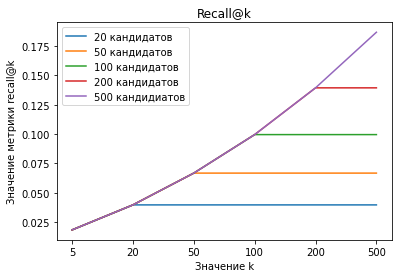

In [27]:
fig, ax = plt.subplots()

plt.xticks(range(6), [5, 20, 50, 100, 200, 500])

for key in rec_dict_1:
    ax.plot(rec_dict_1[key])

ax.set_xlabel('Значение k')
ax.set_ylabel('Значение метрики recall@k')
ax.set_title('Recall@k')
plt.legend(['20 кандидатов', '50 кандидатов', '100 кандидатов', '200 кандидатов', '500 кандидиатов']);

### C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

Судя по всему, наиболее разумным является значение k меньше или равное количеству кандидатов

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [0]:
# your_code

users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [29]:
users_lvl_2.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [30]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1

users_lvl_2.head(4)

,user_id,item_id,flag
0,2070,1105426,1
0,2070,1097350,1
0,2070,879194,1
0,2070,948640,1


In [0]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)

In [32]:
targets_lvl_2.head()

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0
2,2070,879194,0.0
3,2070,948640,0.0
4,2070,928263,0.0


In [33]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [34]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [0]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

In [36]:
targets_lvl_2.shape

(111366, 16)

In [0]:
big_data = data.merge(item_features, on='item_id', how='left')
big_data = big_data.merge(user_features, on='user_id', how='left')

In [38]:
big_data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0,2,PRODUCE,National,ONIONS,ONIONS SWEET (BULK&BAG),40 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Фичи товара

Кол-во покупок в неделю, среднее кол-во покупок в неделю по каждой категории товара

In [0]:
temp_df = big_data.groupby('department').agg({'quantity' : 'sum'}).reset_index()
# создаем временный датафрейм, в котором будут значения количеств всех покупок по каждой категории

In [40]:
temp_df.head()

,department,quantity
0,,0
1,AUTOMOTIVE,61
2,CHARITABLE CONT,3
3,CHEF SHOPPE,754
4,CNTRL/STORE SUP,22


In [0]:
temp_df['average_num_purchases_per_week'] = temp_df['quantity'] / big_data['week_no'].nunique()
# теперь делим количество покупок на количество недель и получаем среднее количество покупок в неделю для каждой категории товара

In [0]:
temp_df = temp_df.rename(columns={'quantity' : 'num_purchases_per_week'})

In [0]:
targets_lvl_2 = targets_lvl_2.merge(temp_df, on=['department'], how='left')
# объединяем обучающий датасет и фичи по категориям 

In [44]:
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,num_purchases_per_week,average_num_purchases_per_week
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,62022,652.863158
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2025562,21321.705263


### Фичи пользователя

Средний чек

In [0]:
temp_df = pd.DataFrame()

In [0]:
temp_df = big_data[['user_id', 'basket_id', 'quantity', 'sales_value', 'department']]

In [47]:
temp_df.head(2)

,user_id,basket_id,quantity,sales_value,department
0,2375,26984851472,1,1.39,PRODUCE
1,2375,26984851472,1,0.82,PRODUCE


In [48]:
temp_df['amount'] = temp_df['quantity'] * temp_df['sales_value']
# считаем сумму по каждому товару

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
temp_df = temp_df.groupby(['user_id'])['basket_id'].count().reset_index().merge(
    temp_df.groupby(['user_id']).agg({'amount' : 'sum'}), on='user_id', how='left')
# получаем количество заказов пользователя и общую сумму всех заказов

In [0]:
temp_df['average_check'] = temp_df['amount'] / temp_df['basket_id']

In [51]:
temp_df.head()

,user_id,basket_id,amount,average_check
0,1,1589,4928.19,3.101441
1,2,655,2210.50,3.374809
2,3,889,144547.93,162.596097
3,4,301,1747.05,5.804153
4,5,219,829.08,3.785753


In [0]:
targets_lvl_2 = targets_lvl_2.merge(temp_df[['user_id', 'average_check']], on=['user_id'], how='left')
# объединяем обучающий датасет и фичи

Кол-во покупок в каждой категории

In [0]:
temp_df = big_data[['user_id', 'quantity', 'department']]

In [0]:
temp_df = temp_df.groupby(['user_id', 'department']).agg({'quantity' : 'sum'}).reset_index()
# получаем количество покупок по каждой категории товара

In [0]:
temp_df = temp_df.rename(columns={'quantity' : 'num_purchases_each_department'})

In [56]:
temp_df.head()

,user_id,department,num_purchases_each_department
0,1,,0
1,1,DELI,58
2,1,DRUG GM,176
3,1,FLORAL,1
4,1,GROCERY,1229


In [0]:
targets_lvl_2 = targets_lvl_2.merge(temp_df, on=['user_id', 'department'], how='left')
# объединяем обучающий датасет и фичи

In [58]:
targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,num_purchases_per_week,average_num_purchases_per_week,average_check,num_purchases_each_department
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,62022,652.863158,1105.636389,24.0
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2025562,21321.705263,1105.636389,2216.0
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,326443,3436.242105,1105.636389,469.0
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,326443,3436.242105,1105.636389,469.0
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,326443,3436.242105,1105.636389,469.0


### **Фичи пары user_id - item_id**

Средняя сумма покупки 1 товара в каждой категории

In [0]:
temp_df = pd.DataFrame()

In [0]:
temp_df= big_data[['user_id', 'item_id', 'department', 'quantity', 'sales_value']]

In [61]:
temp_df.head()

,user_id,item_id,department,quantity,sales_value
0,2375,1004906,PRODUCE,1,1.39
1,2375,1033142,PRODUCE,1,0.82
2,2375,1036325,PRODUCE,1,0.99
3,2375,1082185,PRODUCE,1,1.21
4,2375,8160430,PRODUCE,1,1.50


## Модель

In [0]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [64]:
cat_feats = X_train.columns[2:-4].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [65]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict(X_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


In [67]:
train_preds.shape

(111366,)


**Фичи user_id:**
    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером




**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее кол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 